## TP Statistique N°3

In [269]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from numpy.linalg import eigh
import scipy.stats as stat
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

## Exercice 1. (Le jeu de données contaminé par le robot)
Nous travaillons sur la base de données diabetes de python. La base initiale comporte 442 patients et 10 covariables. La variable Y à expliquer est un score correspondant à l’évolution de la maladie. Pour s’amuser, un robot malicieux a contaminé le jeu de données en y ajoutant 200 variables explicatives inappropriées. Ensuite, non-content d’avoir déjà perverti notre jeu de données, il a volontairement mélangé les variables entre elle de façon aléatoire. Bien entendu le robot a ensuite pris soin d’effacer toute trace de son acte crapuleux si bien que nous ne connaissons pas les variables pertinentes. La nouvelle base de données comporte 442 patients et 210 covariables, notés X. Saurez-vous déjouer les plans de ce robot farceur et retrouver les variables pertinentes ?

## Question 1 - Chargement des données
Importer la base de données data_dm3.csv disponible depuis le lien https://bitbucket.org/ portierf/shared_files/downloads/data_dm3.csv. La dernière colonne est la variable à expliquer. Les autres colonnes sont les variables explicatives. Préciser le nombre de variables explicatives et le nombre d’observations.

In [270]:
# On charge les données dans un DataFrame "dfdata" à partir du fichier csv
url = 'https://bitbucket.org/portierf/shared_files/downloads/data_dm3.csv'
dfdata = pd.read_csv(url, sep=',', header=None)

# On affiche les premières lignes
dfdata.head()

,0,1,2,3,4,5,6,7,8,9,...,201,202,203,204,205,206,207,208,209,210
0,-1.298173,-0.162249,1.223379,1.355554,1.080171,0.634979,0.298741,0.548270,0.731773,1.018645,...,0.588278,0.210106,1.861458,-0.436399,0.279299,-1.416020,-2.332363,0.215096,-0.693319,151.0
1,0.166951,-0.338060,-0.618867,0.759366,1.134281,-0.536844,-0.075120,0.970251,-0.327487,0.717310,...,-0.251054,-0.825716,0.339139,1.119430,0.225958,-0.822288,0.382838,-0.718829,-0.188993,75.0
2,-0.416177,-0.205659,-1.282226,1.675500,1.523746,0.192029,-0.235840,-1.954626,-0.853309,0.892791,...,1.283837,0.372516,-0.652557,-2.579347,0.139267,-1.901196,0.048210,0.220205,0.471588,141.0
3,0.867184,-0.398667,0.093501,0.025971,1.852099,0.789774,0.801775,0.376711,0.853689,0.247953,...,0.446582,0.334733,0.399074,-0.884172,0.723819,1.316367,0.088218,0.619496,1.061662,206.0
4,1.193282,-0.936980,-0.725039,0.766078,0.223489,-1.584622,1.146866,0.086136,-0.088780,-0.945066,...,0.786157,-1.058179,-0.155788,-0.642504,2.040010,-1.703110,-1.901502,1.778811,-0.489853,135.0


In [271]:
# Nombre de variables explicatives : on compte le nombre de colonne sauf la dernière
nb_var_explicatives = len(dfdata.columns[:-1])

# Nombre d'observations : on compte le nombre de ligne dans la première colonne
N = dfdata[0].count()
print("Nombre de variables explicatives : {:d}".format(nb_var_explicatives))
print("Nombre d'observations : {:d}".format(N))

Nombre de variables explicatives : 210
Nombre d'observations : 442


## Question 2 - Etude des des données, centrage et normalisation
Les variables explicatives sont-elles centrées ? Normalisées ? Qu’en est-il de la variable à expliquer ? Tracer un scatter plot de la base de données avec 4 covariables prises au hasard et la variable à expliquer (un scatterplot regroupe les graphes de chacune des variables en fonction de chacune des autres). Commenter les graphiques obtenus.

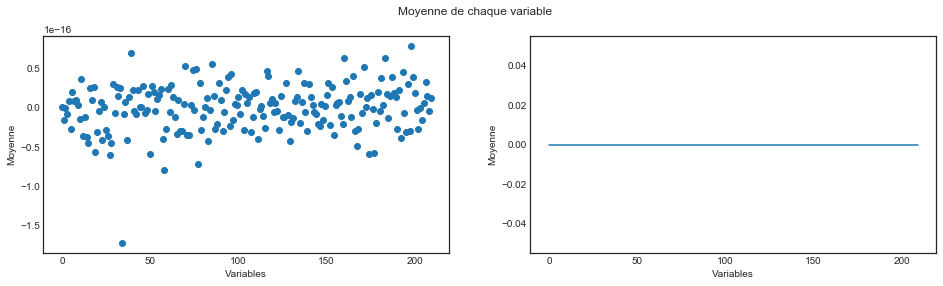

In [272]:
# On ne conserve dans X que les variables explicatives : toutes les colonnes sauf la dernière
X = dfdata.iloc[:,:-1]

# On stocke la variable à expliquer dans Y
Y = dfdata.iloc[:,-1:]

# On trace les graphiques de la moyenne des variables
fig, axs = plt.subplots(1, 2, figsize=(16,4))
axs[0].plot(X.mean(),'o')
axs[0].set_xlabel('Variables')
axs[0].set_ylabel('Moyenne')
axs[1].plot(X.mean().round())
axs[1].set_xlabel('Variables')
axs[1].set_ylabel('Moyenne')
fig.suptitle("Moyenne de chaque variable")
plt.show()

Les valeurs des moyennes de chaque variable est de l'ordre de 1e-16 ce qui est suffisant pour conclure que les variables sont centrées.

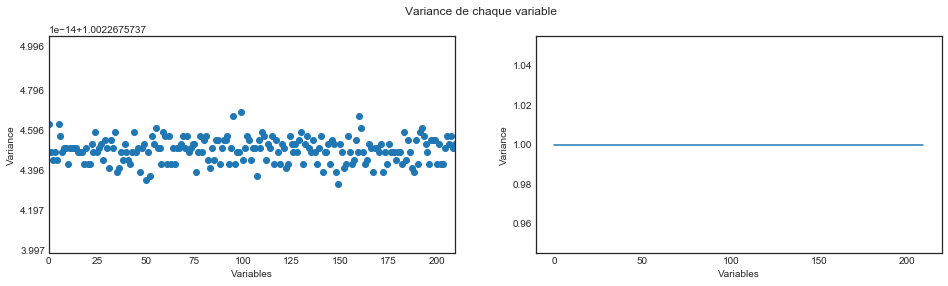

Variance de la première colonne pour exemple : 1.002268


In [274]:
# On trace les graphique de la variance des variables
fig2, axs = plt.subplots(1, 2, figsize=(16,4))
axs[0].plot(X.var(),'o')
axs[0].margins(0,1)
axs[0].set_xlabel('Variables')
axs[0].set_ylabel('Variance')
axs[1].plot(X.var().round())
axs[1].set_xlabel('Variables')
axs[1].set_ylabel('Variance')
fig2.suptitle("Variance de chaque variable")
plt.show()
print("Variance de la première colonne pour exemple : {:f}".format(X[0].var()))

On voit que la variance des variables explicative est située autour de 1.002268 avec des fluctuations très petites (de l'ordre de 1e-14). On peut en conclure que les variables sont normalisées.

In [275]:
# Etude de la variable Y
Y.describe()

,210
count,442.000000
mean,152.133484
std,77.093005
min,25.000000
25%,87.000000
50%,140.500000
75%,211.500000
max,346.000000


La variable à expliquer Y n'est pas standardisée car sa moyenne est de 152 et sa variance (en fait son écart-type) de 77.

Colonnes sélectionnées aléatoirement (plus y en dernier) : [164   1  70 125 210]


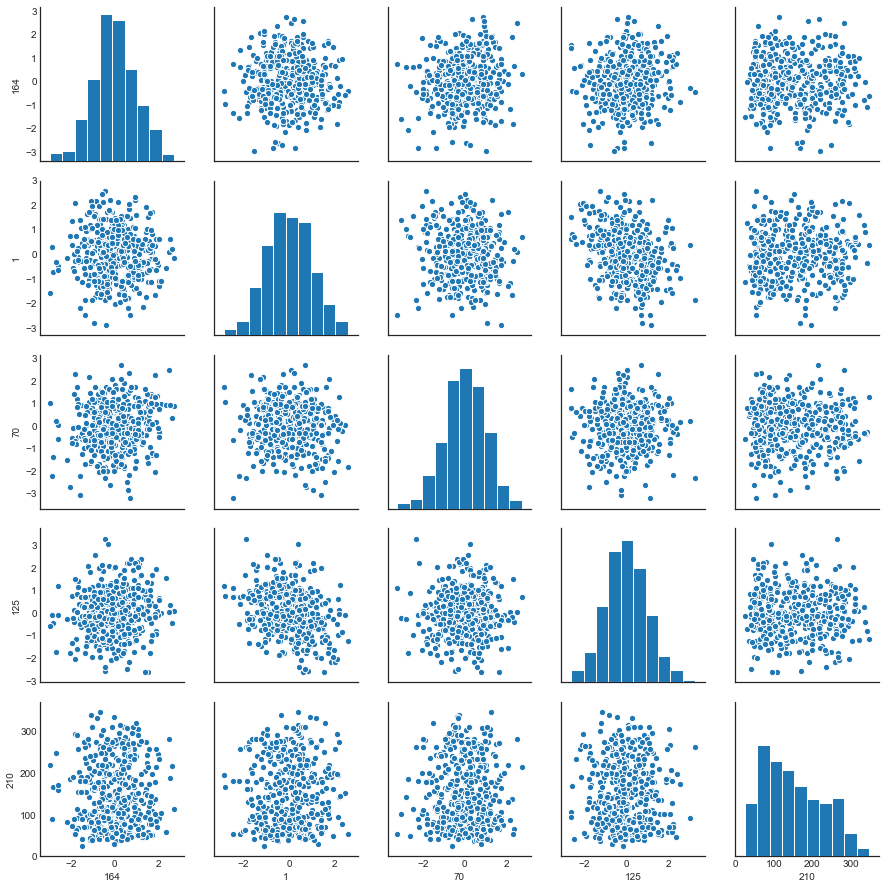

In [277]:
# Choix de 4 variables (colonnes) aléatoirement parmi toutes les variables X
randcol = np.random.randint(0,210,4)
# On ajoute la variable Y
randcol = np.append(randcol,210)
print("Colonnes sélectionnées aléatoirement (plus y en dernier) : {}".format(randcol))

sns.set_style("white")
g = sns.PairGrid(dfdata[randcol])
g.map(plt.scatter, color='white')
g.map_diag(plt.hist, edgecolor="w")
g.map_offdiag(plt.scatter, edgecolor="w", s=40)

### Commentaire
En choisissant aléatoirement des variables explicatives, il y a très peu de chances de tomber sur une "bonne" variable. Celles qui sont choisies apparaissent souvent sans réelle corrélation avec la variable à expliquer et avec une distribution gaussienne.

### Question 3 - Echantillonnage
Echantillon d’apprentissage et de test. Créer 2 échantillons : un pour apprendre le modèle Xtrain, un pour tester le modèle Xtest. On mettra 20% de la base dans l’échantillon ’test’. Donner les tailles de chacun des 2 échantillons. On notera que le nouvel échantillon de covariables Xtrain n’est pas normalizé. Dans la suite, on fera donc bien attention à inclure l’intercept dans nos régression

In [278]:
from sklearn.model_selection import train_test_split

# On split les données d'entrainement(80%) et de test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1, test_size=0.2)

In [280]:
Ntrain = X_train.shape[0]
Ntest = X_test.shape[0]
print("Nb observations d'entraînement : {:d}".format(Ntrain))
print("Nb observations de test : {:d}".format(Ntest))


Nb observations d'entraînement : 353
Nb observations de test : 89


### Question 4 - ACP
Donner la matrice de covariance calculée sur Xtrain. Tracer le graphe de la décroissance des valeurs propres de la matrice de corrélation. Expliquer pourquoi il est légitime de ne garder que les premières variables de l’ACP. On gardera 60 variables dans la suite.

In [290]:
# On calcule la matrice de corrélation avec la fonction de pandas
CorrMatrix = X_train.corr()

# On calcul la matrice de covariance avec la fonction np.cov de numpy
CovMatrix = pd.DataFrame(np.cov(X_train.T))
CovMatrix.head(5)

,0,1,2,3,4,5,6,7,8,9,...,200,201,202,203,204,205,206,207,208,209
0,0.965244,-0.088750,-0.028531,-0.322255,0.138792,0.156892,-0.092566,-0.170225,-0.018161,-0.058034,...,-0.128699,-0.078946,-0.005901,0.014866,-0.086102,-0.003034,-0.134120,-0.042099,0.150938,-0.017102
1,-0.088750,0.999512,0.129679,-0.271167,-0.121233,-0.083455,0.154947,-0.138040,0.024063,-0.123874,...,-0.135175,-0.021461,-0.020549,-0.267122,-0.019931,0.055906,0.002312,-0.134395,-0.067714,0.065489
2,-0.028531,0.129679,1.016230,-0.224909,0.175400,-0.085873,-0.037254,0.061328,-0.037798,-0.158732,...,0.169063,0.017194,0.111473,0.040044,0.020489,0.068604,0.024150,-0.317421,0.021137,-0.091551
3,-0.322255,-0.271167,-0.224909,1.057261,-0.025972,-0.094338,0.190035,-0.057079,0.091709,0.009270,...,0.083522,-0.007513,-0.141887,0.142235,-0.042497,-0.236377,0.070692,0.014035,-0.200941,-0.404201
4,0.138792,-0.121233,0.175400,-0.025972,1.003781,-0.045102,0.002743,0.188519,-0.014004,0.130540,...,0.133294,-0.005165,0.137792,-0.088453,-0.117100,-0.095107,0.045031,-0.079912,0.043582,-0.086527


In [287]:
CorrMatrix.head(5)

,0,1,2,3,4,5,6,7,8,9,...,200,201,202,203,204,205,206,207,208,209
0,1.000000,-0.090356,-0.028807,-0.319000,0.141002,0.155506,-0.093103,-0.172204,-0.018500,-0.058860,...,-0.135498,-0.079772,-0.006072,0.015174,-0.085437,-0.003093,-0.137559,-0.043220,0.154916,-0.017286
1,-0.090356,1.000000,0.128670,-0.263786,-0.121034,-0.081288,0.153151,-0.137230,0.024088,-0.123466,...,-0.139855,-0.021311,-0.020777,-0.267935,-0.019436,0.056020,0.002331,-0.135586,-0.068297,0.065049
2,-0.028807,0.128670,1.000000,-0.216980,0.173666,-0.082952,-0.036518,0.060465,-0.037526,-0.156903,...,0.173472,0.016933,0.111779,0.039834,0.019815,0.068177,0.024140,-0.317589,0.021142,-0.090185
3,-0.319000,-0.263786,-0.216980,1.000000,-0.025211,-0.089343,0.182631,-0.055173,0.089265,0.008983,...,0.084020,-0.007254,-0.139487,0.138716,-0.040293,-0.230299,0.069278,0.013767,-0.197058,-0.390370
4,0.141002,-0.121034,0.173666,-0.025211,1.000000,-0.043838,0.002705,0.187015,-0.013989,0.129833,...,0.137615,-0.005118,0.139023,-0.088533,-0.113944,-0.095098,0.045291,-0.080448,0.043863,-0.085763


### Note
On voit que ces deux matrices ne sont pas égales. Pour retrouver l'égalité avec la matrice de corrélation, il faut calculer la matrice de covariance avec les données normalisées.

In [291]:
# On utlise la fonction eighh pour décomposer la matrice de covariance
# et récupérer ses vecteurs propres et ses valeurs propres
# NB : la fonction eigh est plus efficace pour les matrices symétriques
# Dint contient les valeurs propres, Uint contient les vecteurs propres
Dint, Uint = eigh(CovMatrix)

# on récupère les indices qui trient les valeurs propres en ordre décroissant
idx = Dint.argsort()[::-1]
D = Dint[idx]
U = Uint[:, idx]

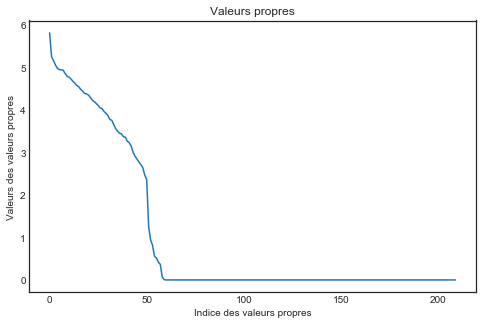

In [293]:
plt.figure(figsize=(8,5))
plt.xlabel('Indice des valeurs propres')
plt.ylabel('Valeurs des valeurs propres')

# On trace les valeurs propres
plt.plot(D)
plt.title("Valeurs propres")
plt.show()

### Commentaire
Le graph montre qu'à partir d'un certain indice autour de 60, les valeurs propres deviennent très proches de zéro. En d'autres termes dans la base de décomposition, au-delà de cet indice les variables ont une très faible variance. C'est pourquoi il est légitime de ne garder que 60 variables dans cette base.

Soit u1 le vecteur propre associé à la plus grande valeur propre, on a : U = (u1...u60)
En calculant Xpca = XU sur les 60 premières variables, on récupère des vecteurs w1=Xu1, w2=Xu2..., w60=Xu60 independants des uns des autres et de variance maximum.

### Question 5 - PCA before OLS
Suivant les observations de la question (Q4), appliquer la méthode de "PCA before OLS" qui consiste à appliquer OLS avec Y et XtrainV(1:60), où V(1:60) contient les vecteurs propres (associés aux 60 plus grandes valeurs propres) de la matrice de covariance. Faire une régression linéaire (avec intercept), puis tracer les valeurs des coefficients (hors intercept). Sur un autre graphique, faire de même avec la méthode des moindres carrés classique.

In [299]:
# On calcule les 60 premières composantes principales dans Xpca
Xpca = X_train @ U[:,:60]
Xpca.head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
438,-1.495035,1.348194,1.640310,-1.783307,-3.499290,-3.758083,-0.278532,3.384614,1.475434,-1.861051,...,1.334723,0.706755,-2.197976,0.695078,0.169764,-0.196092,-1.587226,-0.742565,0.551201,-0.013978
232,1.452014,-2.467190,3.056557,0.211889,1.235818,-1.999949,-0.063333,-1.885742,-3.817781,-1.457328,...,-0.407812,-0.996363,-1.863469,0.151513,-0.158861,-0.158564,-0.234558,-0.254326,0.094982,-0.036707
80,1.228351,0.548785,1.563297,5.398798,2.589271,0.501201,-0.907027,-0.505940,2.790120,-0.107759,...,1.317656,1.688998,1.230382,0.172141,0.360922,0.011671,0.707742,0.171389,0.027035,-0.062996
46,-2.056829,-0.564772,-0.476706,0.361534,-0.938182,-4.491487,0.420381,-1.393296,1.256789,-0.151933,...,-2.922600,-0.293970,0.120328,-1.081555,0.000113,0.193234,0.901963,-0.331883,-0.050420,-0.036515
381,-3.206134,-2.789999,-1.660437,1.083409,-0.377059,-1.053607,0.565282,-1.791987,1.175213,-2.944612,...,-0.631869,-0.641835,-1.270864,0.834882,-0.205520,-0.475092,0.890678,-0.130635,0.167116,0.018121


In [300]:
# Regression avec SKlearn avec l'intercept sur les variables PCA
lin_reg = linear_model.LinearRegression()
lin_reg.fit(Xpca, y_train)
ThetaPCA_OLS = lin_reg.coef_[0]
InterceptPCA_OLS = lin_reg.intercept_[0]

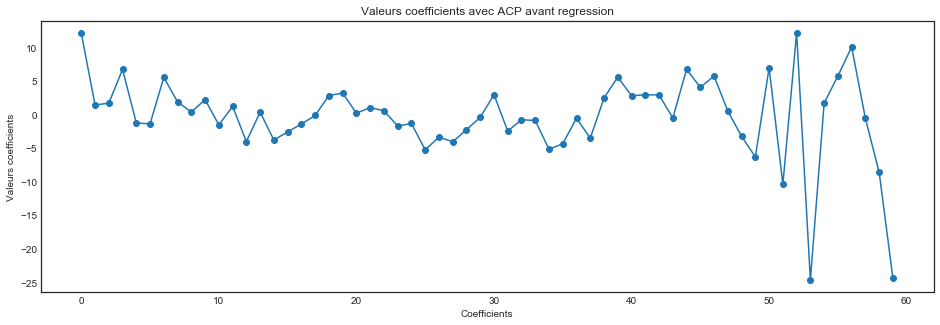

In [301]:
# On trace le graphique des coefficients
plt.figure(figsize=(16,5))
plt.xlabel('Coefficients')
plt.ylabel('Valeurs coefficients')

plt.plot(ThetaPCA_OLS, "-o")
plt.title("Valeurs coefficients avec ACP avant regression")
plt.show()

In [302]:
lin_reg = linear_model.LinearRegression()
lin_reg.fit(X_train, y_train)
ThetaOLS = lin_reg.coef_[0]
InterceptOLS = lin_reg.intercept_[0]

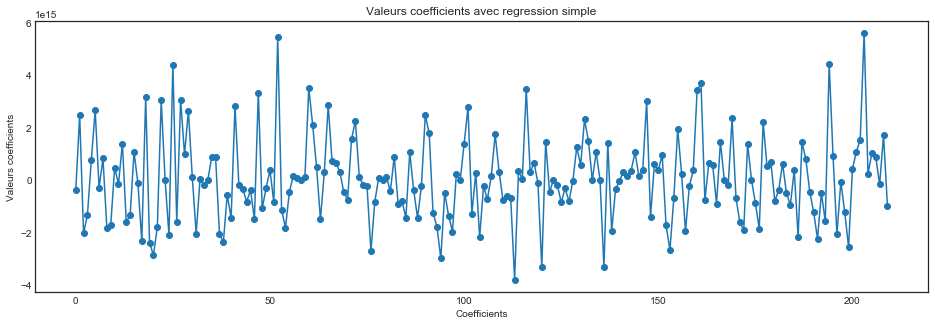

In [304]:
plt.figure(figsize=(16,5))
plt.xlabel('Coefficients')
plt.ylabel('Valeurs coefficients')

plt.plot(ThetaOLS, "-o")
plt.title("Valeurs coefficients avec regression simple")
plt.show()

### Commentaire
On remarque que si on réalise une regression simple sur les données de bases, les valeurs des coefficients explosent et n'ont aucun sens, ce qui est normal étant donné que la majorité des variables ne sont que du bruit aléatoire.

### Question 6 - Intercepts
Donner les valeurs des intercepts pour les 2 régressions précédentes. Donner la valeur moyenne de la variable Y (sur le train set). Les intercepts des 2 questions sont-ils égaux? Commenter. Uniquement pour cette question, centrer et réduire les variables après ACP (de petite dimension). Faire une régression avec ces variables et vérifier que l’intercept est bien égal à la moyenne de Y sur le train.

In [305]:
# Intercept pour PCA avant OLS
print("Intercept PCA avant OLS : {:f}".format(InterceptPCA_OLS))
print("Intercept avec OLS simple : {:f}".format(InterceptOLS))
print("Moyenne de y sur le train set : {:f}".format(float(y_train.mean())))

Intercept PCA avant OLS : 150.583057
Intercept avec OLS simple : 152.251771
Moyenne de y sur le train set : 153.376771


### Commentaire
Les deux intercepts ne sont pas rigoureusement égaux mais sont proches malgré tout. On remarque que l'intercept pour la méthode de PCA avant OLS est plus proche de la moyenne des y.

In [313]:
# On renormalise les variables après ACP
XpcaNorm = (Xpca - Xpca.mean()) / Xpca.std()

# Pour vérifier on peut utiliser Scikit-Learn et constater que le résultat est le même
# et notamment que la fonction de scikit-learn realisé un centrage des données de base
# pca = PCA(n_components=60)
# XpcaSKlearn = pca.fit_transform(X_train)
# lin_reg.fit(XpcaSKlearn, y_train)

# On réalise une regression sur les variables normalisées
lin_reg = linear_model.LinearRegression()
lin_reg.fit(XpcaNorm, y_train)

# On enregistre l'intercept
InterceptPCA_OLS = lin_reg.intercept_[0]

print("Intercept avec PCA + OLS avec renormalisation : {:f}".format(InterceptPCA_OLS))
print("Moyenne de y sur le train set : {:f}".format(float(y_train.mean())))

Intercept avec PCA + OLS avec renormalisation : 153.376771
Moyenne de y sur le train set : 153.376771


### Commentaire
Ici, pour la PCA avec renormalisation, on trouve que l'intercept est égal à la moyenne des Y sur le train set.

### Question 7 - Résidus OLS et PCA before OLS
Pour les 2 méthodes (OLS et PCA before OLS) : Tracer les résidus de la prédiction sur l’échantillon test. Tracer leur densité (on pourra par exemple utiliser un histogramme). Calculer le coefficient de détermination sur l’échantillon test. Calculer le risque de prédiction sur l’échantillon test.

In [314]:
# Calcul des résidus de la prédiction pour OLS simple

# Regression
regOLS = linear_model.LinearRegression()
regOLS.fit(X_train, y_train)

# Prédiction sur l'échantillon test et résidus
predOLS = regOLS.predict(X_test)
ResiduOLS = y_test - predOLS

In [317]:
# Calcul des résidus de la prédiction pour PCA avant OLS

# Transformation des données test pour la PCA
Xpca_test = X_test @ U[:,:60]

# Regression
regPCAOLS = linear_model.LinearRegression()
regPCAOLS.fit(Xpca, y_train)

# Prédiction sur l'échantillon test et résidus
predPCA_OLS = regPCAOLS.predict(Xpca_test)
ResiduPCA_OLS = y_test - predPCA_OLS

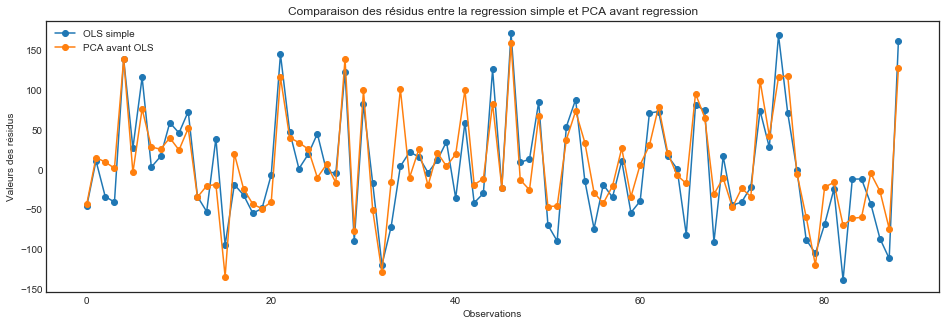

In [318]:
plt.figure(figsize=(16,5))
plt.xlabel('Observations')
plt.ylabel('Valeurs des résidus')

plt.plot(np.arange(89),ResiduOLS, "-o", label="OLS simple")
plt.plot(np.arange(89), ResiduPCA_OLS, "-o", label="PCA avant OLS")
plt.title("Comparaison des résidus entre la regression simple et PCA avant regression")
plt.legend()
plt.show()

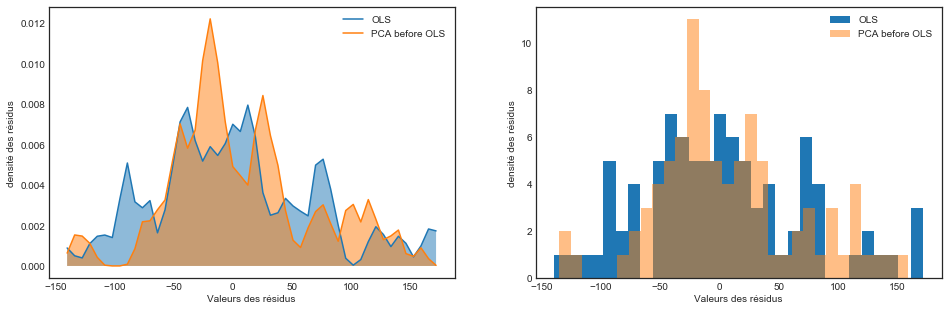

In [320]:
# Densité avec un noyau gaussien
from statsmodels.nonparametric.kde import KDEUnivariate

# Densité des résidus avec OLS simple
kde_OLS = KDEUnivariate(ResiduOLS)
kde_OLS.fit(bw=5, kernel='gau')
x_grid = np.linspace(-140, 172)
pdf_est_OLS = kde_OLS.evaluate(x_grid)

# Densité des résidus avec PCA + OLS
kde_PCAOLS = KDEUnivariate(ResiduPCA_OLS)
kde_PCAOLS.fit(bw=5, kernel='gau')
x_grid = np.linspace(-140, 172)
pdf_est_PCAOLS = kde_PCAOLS.evaluate(x_grid)

# On trace les graphes
fig3, axs = plt.subplots(1, 2, figsize=(16,5))
axs[0].plot(x_grid, pdf_est_OLS, label='OLS')
axs[0].fill_between(x_grid, 0, pdf_est_OLS, alpha=0.5)

axs[0].plot(x_grid, pdf_est_PCAOLS, label='PCA before OLS')
axs[0].fill_between(x_grid, 0, pdf_est_PCAOLS, alpha=0.5)
axs[0].set_xlabel('Valeurs des résidus')
axs[0].set_ylabel('densité des résidus')
handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend()

# Graphe des densités sous forme d'histogrammes
axs[1].hist(ResiduOLS.T, bins=30, label="OLS")
axs[1].hist(ResiduPCA_OLS.T, bins=30, label="PCA before OLS", alpha=0.5)
axs[1].set_xlabel('Valeurs des résidus')
axs[1].set_ylabel('densité des résidus')
handles2, labels2 = axs[1].get_legend_handles_labels()
axs[1].legend()

plt.show()

In [323]:
R2_OLS = regOLS.score(X_test,y_test)
R2_PCAOLS = regPCAOLS.score(Xpca_test,y_test)

# Alternative : utiliser la fonction r2_score(y_true, y_pred) qui donne le même résultat
# R2_OLS = r2_score(y_test, regOLS.predict(X_test))
# R2_PCAOLS = r2_score(y_test, regPCAOLS.predict(Xpca_test))

print("R2 coefficient de détermintation avec OLS simple : {:f}".format(R2_OLS))
print("R2 coefficient de détermintation avec PCA avant OLS : {:f}".format(R2_PCAOLS))

R2 coefficient de détermintation avec OLS simple : 0.115510
R2 coefficient de détermintation avec PCA avant OLS : 0.298476


### Commentaire
On constate que le coefficient de détermination est très faible dans le cas de l'OLS simple et relativement moyen dans le cas de la méthode de PCA avant OLS : entre d'autres terme les variables n'apportent pas beaucoup d'information pour prédire Y sur l'échantillon de test. Le coefficient avec PCA est meilleur, mais il prend en compte encore trop de bruit (trop de variable inconsistantes) pour donner un bon résultat. Il faut donc rechercher les variables significatives.

In [324]:
# Calcul du risque de prédiction OLS
RpredOLS = (1/Ntest)*np.sum((y_test - predOLS)**2)
print("Risque de prédiction OLS : {:.2f}".format(float(RpredOLS)))

# Alternative avec la fonction mean_squared_error qui donne le même résultat
# print("Risque de prédiction OLS sklearn : {:.2f}".format(mean_squared_error(y_pred=predOLS, y_true=y_test)))

# Calcul du risque de prédiction PCA avant OLS
RpredPCA_OLS = (1/Ntest)*np.sum((y_test - predPCA_OLS)**2)
print("Risque de prédiction PCA avant OLS : {:.2f}".format(float(RpredPCA_OLS)))

# Alternative avec la fonction mean_squared_error qui donne le même résultat
# print("Risque de prédiction PCA avant OLS sklearn : {:.2f}".format(mean_squared_error(y_pred=predPCA_OLS, y_true=y_test)))

Risque de prédiction OLS : 4713.42
Risque de prédiction PCA avant OLS : 3738.40


### Commentaire
De manière logique, on constate que le risque de prédiction avec OLS simple et plus élevé qu'avec la PCA avant l'OLS. Dans la suite nous utiliserons la fonction mean_squared_error de Scikit-Learn pour calculer le risque.

### Question 8 - Forward selection method
Appliquer la méthode de forward variable sélection. On pourra utiliser la statistique du test de nullité du coefficient (comme vu en cours). Pour l’instant, on ne met pas de critère d’arret sur la méthode. C’est à dire que l’on ajoute une variable à chaque étape jusqu’à retrouver la totalité des variables. Afficher l’ordre de séléction des variables.

In [325]:
# On construit X_tilde à partir de X_train auquel on ajoute une colonne de 1
X_tilde = np.array(X_train, dtype=np.float)
X_tilde = np.hstack((np.ones((Ntrain,1)),X_tilde))

p = X_tilde.shape[1]

tstat = np.zeros((p,p)) # tstat : tableau des T-stat calculées à chaque étape
pval = np.zeros((p,p)) # pval : tableau des p-value calculées à chaque étape
pval_mem = np.zeros(p) # pval_mem : tableau des p-value sélectionnées à chaque étape

# Au premier passage les résidus valent exactement les valeurs y_train
resids = np.array(y_train, dtype=np.float).ravel()

var_sel = [] # var_sel : liste des indices des variables sélectionnées

# var_remain : liste des variables restantes à considérer
# à chaque étape on enlèvera l'élément de la liste correspondant à
# l'indice de la variable sélectionnée
var_remain = list(range(p))

regr = linear_model.LinearRegression(fit_intercept = False)

for k in range(p): 
    resids_mem = np.zeros((p, Ntrain))

    for i in var_remain:
        xtmp = X_tilde [:, [i]]
        
        # On effectue la régression de la variable en cours sur les résidus
        regr.fit(xtmp , resids)

        # On calule les résidus en retranchant ceux de l'étape précédente
        resids_mem [i,:] = regr.predict(xtmp) - resids
        
        # On calcule sigma2, la statistique de test de nullité et la p-value de la variable en cours        
        sigma2_tmp = (1 / (Ntrain - 1)) * np.sum (resids_mem[i,:] ** 2)
        tstat[k,i] = np.abs(regr.coef_) / np.sqrt(sigma2_tmp / (xtmp.T @ xtmp))
        pval[k,i] =   2 * (1 - stats.t.cdf(np.abs(tstat[k,i]), Ntrain - 1))

    # On enregistre la meilleure variable, celle qui maximise la Statistique, dans var_sel
    best_var = np.argmax(tstat[k,:])

    var_sel.append(best_var)
    # On enregistre les résidus
    resids = resids_mem[best_var,:]
    # On enregistre la p-value de la meilleure variable
    pval_mem [k] = pval[k,best_var]
    # On supprime l'indice de la variable sélectionnée pour la prochaine boucle
    var_remain = np.setdiff1d(var_remain,var_sel)

In [332]:
print("Indices des variables sélectionnées dans l'ordre sans critère d'arrêt : ")
print("Attention, l'indice des variables a été recalé et -1 montre la variable intercept")
np.array(var_sel) -1

Indices des variables sélectionnées dans l'ordre sans critère d'arrêt : 
Attention, l'indice des variables a été recalé et -1 montre la variable intercept


array([ -1,  58, 123,  84, 172,  43, 187, 110, 133, 208,  14,  34, 159,
       147, 135,  41, 167, 112, 134, 183,  45,  39, 154, 130,  47,  99,
       174,  77,  85,  66, 178, 117, 201, 189, 199, 166,  31,  79, 155,
        33, 162, 122,  98,  26,  95, 200,  53, 190, 146, 176, 175, 179,
       173, 156,  23, 124,  16,  75,  82,  80,   9, 169,  42,   8,  64,
        86, 142,  36, 126,  19,  30, 141,  17,  56, 132,   6, 205, 185,
        11, 125, 168, 158,  48, 137, 153,   4,  32, 170, 194, 191,  78,
       198,  57,  97,   2,  74, 203, 207, 143,  55,  44,  18,  52, 165,
       192,  24, 202, 127,  25, 145, 148, 128,  72,  62, 100,  46,   7,
        87,  12,  15,  89, 181, 139, 107, 161,   3, 102, 109,  65,  96,
       103,   0,  21,  93,  20,  27, 120, 121, 116,  83, 206, 151, 104,
        38,  29,  60, 184, 119,  28,  61, 111,  90, 113, 152,  68, 136,
        67,  69,  10, 157,  81, 188, 115, 101, 129,  13,  37, 186, 105,
       144, 180, 131,  91,  59,  70, 106, 209, 138, 164, 140,  6

### Question 9 - Forward selection avec critère d'arrêt et graphes de p-values
Critère d’arrêt : On décide d’arrêter lorsque la p-valeur dépasse 0.1. Illustrer la méthode en donnant (i) les 3 graphes des statistiques obtenues lors de la sélection de la 1er, 2eme et 3eme variables (en abscisse : l’index des variables, en ordonné : la valeur des stats) , (ii) le graphe des 50 premières p-valeurs (dont chacune est associée à la variable sélectionnée). Sur ce même graphe, on tracera la ligne horizontale d’ordonnée 0.1. Enfin on donnera la liste des variables sélectionnées.

In [333]:
# On refait tout le traitement mais on ajoute un test pour la valeur à 0.1
# Comme il est demandé de tracer les 50 premières p-value, en fait on ne va pas s'arrêter
# mais on enregistre dans un liste séparée les variables dont la p-value est inférieure à 0.1

# Critère de sélection alpha = 0.1
alpha = 0.1

# On construit X_tilde à partir de X_train auquel on ajoute une colonne de 1
X_tilde = np.array(X_train, dtype=np.float)
X_tilde = np.hstack((np.ones((Ntrain,1)),X_tilde))

p = X_tilde.shape[1]

tstat = np.zeros((p,p)) # tstat : tableau des T-stat calculées à chaque étape
pval = np.zeros((p,p)) # pval : tableau des p-value calculées à chaque étape
pval_mem = np.zeros(p) # pval_mem : tableau des p-value sélectionnées à chaque étape

# Au premier passage les résidus sont exactement les valeurs y_train
resids = np.array(y_train, dtype=np.float).ravel()

var_sel = [] # liste des indices des variables sélectionnées

# liste des incides des variables sélectionnées limitées à celles ayant
# une p_value <= alpha
var_sel_lim = []
finListe = False # Booleen qui sert à savoir si on doit continuer d'ajouter à la liste

# var_remain : liste des variables restantes à considérer
# à chaque étape on enlèvera l'élément de la liste correspondant à
# l'indice de la variable sélectionnée
var_remain = list(range(p))

regr = linear_model.LinearRegression(fit_intercept = False)

for k in range(p): 
    resids_mem = np.zeros((p, Ntrain))

    for i in var_remain:
        xtmp = X_tilde [:, [i]]
        
        # On effectue la régression de la variable en cours sur les résidus
        regr.fit(xtmp , resids)

        # On calule les résidus en retranchant ceux de l'étape précédente
        resids_mem [i,:] = regr.predict(xtmp) - resids
        
        # On calcule sigma2, la statistique de test de nullité et la p-value de la variable en cours        
        sigma2_tmp = (1 / (Ntrain - 1)) * np.sum (resids_mem [i,:] ** 2)
        tstat[k,i] = np.abs(regr.coef_) / np.sqrt(sigma2_tmp / (xtmp.T @ xtmp)) 
        pval[k,i] =   2 * (1 - stats.t.cdf(tstat[k,i], Ntrain - 1))

    # On enregistre la variable qui maximise la Statistique
    best_var = np.argmax(tstat[k,:])
    
    #Si sa p-value est inférieure à 0.1 et qu'on n'a pas déjà dépassé
    # la limite préalablement on l'ajoute à la liste limitée
    if pval[k,best_var] <= alpha and finListe is False: 
        var_sel_lim.append(best_var)
    else:
        # Une fois qu'on a dépassé 0.1 on n'ajoute plus de variable dans var_sel_lim
        # même si sa p-value est inférieure à 0.1
        finListe = True

    # Dans tous les cas on ajoute la meilleure variable dans la liste globale
    var_sel.append(best_var)
    
    # On enregistre la p-value de la meilleure variable
    pval_mem [k] = pval[k,best_var]

    # On enregistre les résidus
    resids = resids_mem[best_var,:]

    # On supprime l'indice de la variable sélectionnée pour la prochaine boucle
    var_remain = np.setdiff1d(var_remain,var_sel)

In [336]:
print("Indices des variables sélectionnées dans l'ordre avec critère d'arrêt : ")
print("-1 montre la variable correspondant à l'intercept")
np.array(var_sel_lim) - 1

Indices des variables sélectionnées dans l'ordre avec critère d'arrêt : 
-1 montre la variable correspondant à l'intercept


array([ -1,  58, 123,  84, 172,  43, 187, 110, 133, 208,  14,  34, 159,
       147, 135])

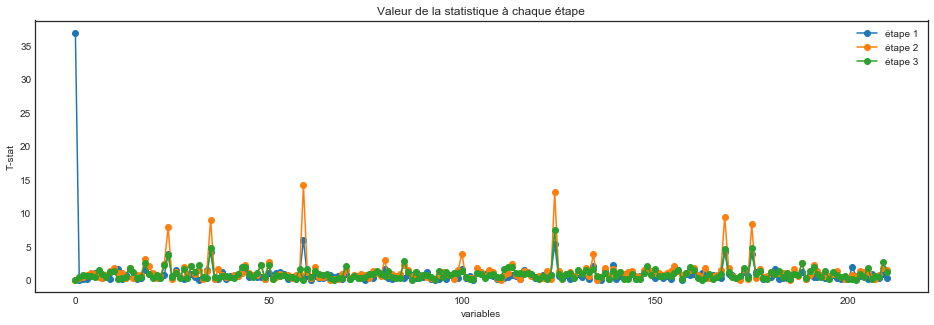

In [337]:
# On trace les valeurs de test pour les 3 premières étapes
plt.figure(figsize=(16,5))
for k in range(3): 
    plt.plot(np.arange(p),tstat[k,:], '-o',label='étape ' + str(k + 1))
plt.legend()
plt.title("Valeur de la statistique à chaque étape")
plt.xlabel("variables")
plt.ylabel("T-stat")
plt.show()

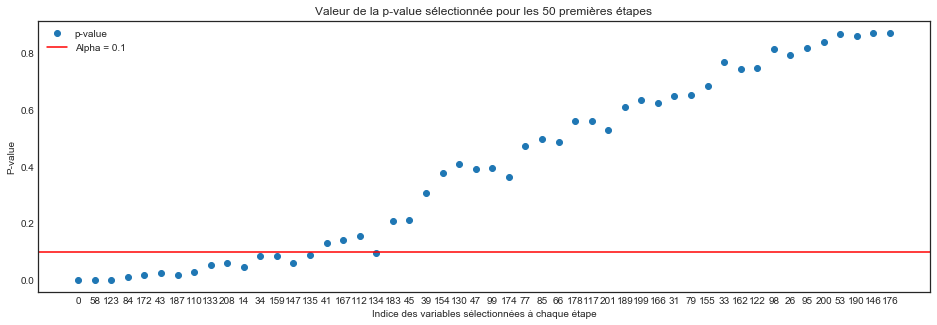

In [338]:
# On récupère dans un DataFrame les pvalues en utilisant l'array des variables sélectionnées comme index
# Ici on prend toutes les variables pour pouvoir tracer le graph comme demandé
dfpval = pd.DataFrame(pval_mem, index=np.array(var_sel))

# On trace le graphe des p-value pour les 50 premières valeurs
plt.figure(figsize=(16,5))
plt.plot(np.arange(50),dfpval[:50], "o", label="p-value")
plt.axhline(y=alpha, color='r', linestyle='-', label="Alpha = " + str (alpha))
plt.legend()
plt.title("Valeur de la p-value sélectionnée pour les 50 premières étapes")
plt.xlabel("Indice des variables sélectionnées à chaque étape")

# Pour le indice des variables il faut faire attention : 0 c'est l'intercept
# pour les autres c'est l'indice - 1 pour tenir compte de la première colonne de 1
plt.xticks(np.arange(50),np.append([0],dfpval.index[1:50] -1))
plt.ylabel("P-value")
plt.show()

### Commentaire
On remarque qu'il arrive qu'une p-value soit sous le seuil des 0.1 après plusieurs variables ayant une p-value supérieure au seuil. Dans ce cas la variable n'est pas incluse, car on s'arrête dès que l'on a dépassé 0.1 pour la première fois.

In [344]:
print("Liste des meilleures variables avec critère d'arrêt à {:.1f} (-1 indique l'intercept) :".format(alpha))
np.array(var_sel_lim) - 1

Liste des meilleures variables avec critère d'arrêt à 0.1 (-1 indique l'intercept) :


array([ -1,  58, 123,  84, 172,  43, 187, 110, 133, 208,  14,  34, 159,
       147, 135])

### Question 10 - OLS après Forward selection
Appliquer OLS sur les variables sélectionnées. Donner le risque de prédiction obtenu l’échantillon test et le comparer à ceux de OLS et PCA before OLS.

In [346]:
# On enregistre les indices des meileures variables sans l'intercept
IndMeilleuresVariables = np.array(var_sel_lim)[1:] - 1

# On lance la régression avec les meilleures variables + l'intercept
regFwd = linear_model.LinearRegression()
regFwd.fit(X_train[IndMeilleuresVariables], y_train)

# On prédit sur l'échantillon de test
PredFwdOLS = regFwd.predict(X_test[IndMeilleuresVariables])
RpredFwdOLS = mean_squared_error(y_pred=PredFwdOLS, y_true=y_test)

print("Risque de prédiction avec OLS simple : {:.2f}".format(float(RpredOLS)))
print("Risque de prédiction avec PCA avant OLS : {:.2f}".format(float(RpredPCA_OLS)))
print("Risque de prédiction avec Forward selection puis OLS : {:.2f}".format(RpredFwdOLS))

R2_FwdOLS = regFwd.score(X_test[IndMeilleuresVariables],y_test)
print("\nR2 avec Forward selection puis OLS : {:f}".format(R2_FwdOLS))

Risque de prédiction avec OLS simple : 4713.42
Risque de prédiction avec PCA avant OLS : 3738.40
Risque de prédiction avec Forward selection puis OLS : 3915.52

R2 avec Forward selection puis OLS : 0.265239


### Commentaire
A l'issue de la regression précédée de la méthode de Forward selection, on constate que le risque de prédiction est inférieur au risque de la regression OLS simple, mais supérieur à la méthode PCA puis OLS. Le coefficient de détermination de la méthode de Forward sélection est relativement faible malgré tout.

**Attention** ce résultat est très dépendant du random_state choisi au départ lors du split initial des données entre X_train et X_test. Avec d'autres valeurs de random_state, le risque est parfois déscendu bien plus bas et donc le R2 était meilleur, jusqu'à 0.5, 0.6.

### Question 11 - Préparation validation croisée
Afin de préparer la validation croisée, séparer l’échantillon train en 4 parties (appelées ”folds”) de façon aléatoire. On affichera les numéros d’échantillon sélectionnés dans chaque fold.

**Première méthode** : j'ai fait un tirage aléatoire dans le jeu d'indice de X_train et utilisé la fonction split de Numpy pour obtenir 4 parties. Problème : ces tirages ne garantissent pas une répartition homogène car il se peut que certaines parties n'aient que très peu d'éléments, voire 0 lorsque deux des nombres tirés sont consécutifs.

In [347]:
# On utilise la fonction split de numpy sur un tirage aléatoire de 3 indices
# parmi les Ntrain pour obtenir 4 parties. Pour éviter de choisir les indices
# 0 et Ntrain, on tire entre 1 et Ntrain -1
IndicesAleatoires = np.sort(np.random.randint(1,Ntrain-1,3))
print("indices aléatoires : ", IndicesAleatoires)
fold1, fold2, fold3, fold4 = np.split(np.array(X_train.index), IndicesAleatoires)


indices aléatoires :  [ 38 168 276]


In [348]:
print("Fold1 : {:d} \nFold2 : {:d} \nFold3 : {:d} \nFold4 : {:d}".format(len(fold1),len(fold2),len(fold3),len(fold4)))

Fold1 : 38 
Fold2 : 130 
Fold3 : 108 
Fold4 : 77


In [349]:
# les index de chaque fold contiennent les numéros d'échantillons sélectionnés.
# Attention, les numéros d'échantillon de X_train étaient déjà une sélection aléatoire
# des 442 échantillons de base, de sorte que les numéros d'échantillon des 4 folds
# obtenus à l'issu de ce split peuvent être toute valeur entre 0 et 441
# Pour exemple, on affiche les numéros des échantillons du premier fold
fold1

array([438, 232,  80,  46, 381, 224,  85, 338,  81, 400, 369, 233, 260,
       228, 185, 122,  11, 117, 139, 218,  93, 420, 168, 324,  41, 180,
       162,  95, 106,  92,  66, 370,  23, 327,  13, 326,  61, 189])

**Deuxième méthode** : j'a utilisé la fonction Kfold de Scikit-learn qui permet une répartition plus homogène de la taille des folds

In [350]:
from sklearn.model_selection import KFold

# Partage en 4 parties dont 3 pour l'entrainement et 1 pour les test
# avec un mélange aléatoire
kf = KFold(n_splits=4, shuffle=True, random_state=1)

# On affiche les numéro des index de chaque échantillon séparés
# Attention, on travaille sur les index de X_train et ce que l'on récupère
# c'est un ensemble d'index
for i, CVindex in enumerate(kf.split(X_train.index)):
    print("Fold n° ", i+1, "TEST:", X_train.index[CVindex[1]])

Fold n°  1 TEST: Int64Index([381, 224,  85, 233, 260, 185, 139,  95,  92, 179,  91, 120, 337,
            374, 131, 201,  51, 112,   9, 287,  16,   0,  70, 150, 342, 163,
            412, 415, 354, 355, 245, 361, 418, 250, 113, 378, 388, 382, 350,
             28,  55, 341, 362, 309, 432,  21, 248, 137, 217, 345, 181, 379,
            358, 103, 220,  94, 193, 202,  96, 301,  36,  75, 149,   2, 151,
            190, 366, 288, 136, 166, 428, 155, 367, 336, 308,  43, 280,   3,
            387, 410, 316,   1, 241, 413, 178, 335,  72, 396,  37],
           dtype='int64')
Fold n°  2 TEST: Int64Index([438,  81, 400,  11, 117, 218, 106, 370,  23, 327,  13, 326, 271,
            340, 191, 320, 332, 328, 414, 403, 339, 330, 125,  12, 187, 325,
             88, 111, 426, 261, 167, 223,  42, 434, 323, 100, 227, 135, 300,
             44, 416,  84,  32,  99,  48,  33, 234,  24, 205, 134, 291,  97,
            278, 118, 176, 406, 140, 423, 269, 240,  77, 263,  52, 262, 417,
             74, 279, 126

### Question 12 - Ridge avec validation croisée
Appliquer la méthode de la régression ridge. Pour le choix du paramètre de régularisation, on fera une validation croisée sur les ”folds” définies lors de la question précédente. A tour de rôle chacune des ”folds” servira pour calculer le risque de prédiction alors que les autres seront utilisées pour estimer le modèle. On moyennera ensuite les 4 risques de prédictions. On donnera la courbe du risque de validation croisée en fonction du paramètre de régularisation (on veillera à bien choisir l’espace de définition pour le graphe). Donner le paramètre de régularisation optimal et la valeur du risque sur le test.

In [352]:
from sklearn.linear_model import Ridge

Nbfold = 4

# Grille de valeurs de lambda logarithmique : choisie après plusieurs essais
# 20 valeurs en échelle log de 1 à 1000
lambdaRange = np.logspace(0.1, 3.0, num=20)

# Initialisation des tableaux d'erreur et du R2
ErrorPred = np.zeros((Nbfold,len(lambdaRange)))    
R2 = np.zeros((Nbfold,len(lambdaRange))) 

# Pour chaque fold
for i, CVindex in enumerate(kf.split(X_train.index)):
    
    # On récupère le jeu de données constitué des 3 folds
    X_RidgeTrain = X_train.loc[X_train.index[CVindex[0]]]
    y_RidgeTrain = y_train.loc[X_train.index[CVindex[0]]]
    
    # On centre les données
    X_RidgeTrainC = X_RidgeTrain - X_RidgeTrain.mean()
    y_RidgeTrainC = y_RidgeTrain - y_RidgeTrain.mean()
    
    # On récupère les données du fold de validation i
    X_RidgeTest = X_train.loc[X_train.index[CVindex[1]]]
    y_RidgeTest = y_train.loc[X_train.index[CVindex[1]]]
  
    # On centre les données
    X_RidgeTestC = X_RidgeTest - X_RidgeTest.mean()
    y_RidgeTestC = y_RidgeTest - y_RidgeTest.mean()

    # On initialise les tableaux  de variables pour enregistrer les valeurs trouvées pour chaque lambda
    coefRidge = np.zeros((len(lambdaRange),X_RidgeTrain.shape[1]))
    PredRidge = np.zeros((len(lambdaRange),y_RidgeTest.shape[0]))

    # Pour chaque valeur de lambda, on fait la regression, puis la prédiction sur le fold de test
    # et on enregistre l'erreur quadratique et le R2 obtenue à chaque passage
    for l, value in enumerate(lambdaRange):
        clf = Ridge(alpha=value, fit_intercept=False)
        clf.fit(X_RidgeTrainC, y_RidgeTrainC)
        coefRidge[l,:] = clf.coef_
        PredRidge[l,:] = clf.predict(X_RidgeTestC)[:,0]
        ErrorPred[i,l] = mean_squared_error(y_pred=PredRidge[l,:],y_true=y_RidgeTestC)
        R2[i,l] = clf.score(X=X_RidgeTestC, y=y_RidgeTestC)

        
# On calcule la moyenne des erreurs de chaque Cross-validation
# et on choisit l'indice de celle qui a donné l'erreur minimum
MinErrorInd = ErrorPred.mean(axis=1).argmin()

# On récupère la valeur de lambda qui a donné l'erreur minimum dans la Cross-Validation choisie précédemment
bestLambdaParCV = lambdaRange[ErrorPred[MinErrorInd,:].argmin()]
bestErrorParCV = ErrorPred[MinErrorInd,:].min()
bestR2 = R2[MinErrorInd,:].max()
print("Risque le plus faible atteint pour la CV n° {:d} avec la valeur lambda : {:.2f}".format(MinErrorInd+1,bestLambdaParCV))
print("Risque correspondant sur la CV n° {:d} : {:.4f}".format(MinErrorInd+1, bestErrorParCV))
print("R2 associé au meilleur lambda de la CV n° {:d} : {:.4f}".format(MinErrorInd+1, bestR2))

# Pour trouver le meilleur lamba, on prend l'indice qui a obtenu
# le plus faible risque sur tous les folds par lambda
bestLambda = lambdaRange[ErrorPred.mean(axis=0).argmin()]
bestError = ErrorPred.mean(axis=0).min()
print("\nLambda correspondant au risque moyen le plus faible : {:.2f}".format(bestLambda))
print("Meilleur risque en moyenne : {:.4f}".format(bestError))


Risque le plus faible atteint pour la CV n° 3 avec la valeur lambda : 121.40
Risque correspondant sur la CV n° 3 : 2396.4823
R2 associé au meilleur lambda de la CV n° 3 : 0.4994

Lambda correspondant au risque moyen le plus faible : 60.11
Meilleur risque en moyenne : 3242.6065


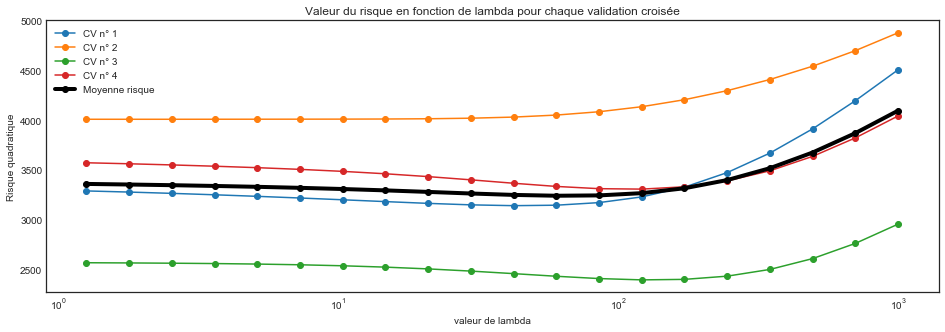

In [353]:
# On trace sur un même graphe les courbes du risque de chaque fold pour toutes les valeurs de lambda
# On trace également la moyenne des folds
plt.figure(figsize=(16,5))
for k in range(Nbfold): 
    plt.plot(lambdaRange,ErrorPred[k,:], '-o',label='CV n° ' + str(k + 1))

plt.plot(lambdaRange, ErrorPred.mean(axis=0), "-ok", linewidth=4, label='Moyenne risque')
plt.legend()
plt.title("Valeur du risque en fonction de lambda pour chaque validation croisée")
plt.xlabel("valeur de lambda")
plt.ylabel("Risque quadratique")
plt.xscale("log")
plt.show()

In [357]:
# On refait une estimation sur l'ensemble des valeurs avec le meilleur lambda pour recalibrer
clf2 = Ridge(alpha=bestLambda, fit_intercept=False)

# On centre les données d'entraînement
X_TrainC = X_train - X_train.mean()
y_TrainC = y_train - y_train.mean()

# On centre les données de test
X_TestC = X_test - X_test.mean()
y_TestC = y_test - y_test.mean()

# On fit l'ensemble des données d'entraînement
clf2.fit(X_TrainC, y_TrainC)

# On prédit sur l'échantillon de test et on affiche l'erreur et le R2 final
PredRidge2 = clf2.predict(X_TestC)
ErrorPred2 = mean_squared_error(y_pred=PredRidge2,y_true=y_TestC)
R2Final = clf2.score(X=X_TestC, y=y_TestC)

print("Rappel de la valeur de lambda, le paramètre de régularisation : {:.2f}".format(bestLambda))
print("Risque final sur échantillon de test après re-calibration : {:.4f}".format(ErrorPred2))
print("R2 final associé sur échantillon de test : {:.4f}".format(R2Final))

print("\nPour rappel :")
print("Risque de prédiction avec OLS simple : {:.2f}".format(float(RpredOLS)))
print("Risque de prédiction avec PCA avant OLS : {:.2f}".format(float(RpredPCA_OLS)))
print("Risque de prédiction avec Forward selection puis OLS : {:.2f}".format(RpredFwdOLS))

Rappel de la valeur de lambda, le paramètre de régularisation : 60.11
Risque final sur échantillon de test après re-calibration : 3728.1122
R2 final associé sur échantillon de test : 0.3004

Pour rappel :
Risque de prédiction avec OLS simple : 4713.42
Risque de prédiction avec PCA avant OLS : 3738.40
Risque de prédiction avec Forward selection puis OLS : 3915.52


### Commentaire
On constate que la méthode Ridge donne ici un résultat comparable au niveau du risque à celui de la méthode PCA avant OLS. Encore une fois avec une forte dépendance au random_state choisi au départ.

### Question 13 - LassoCV
A l’aide de la fonction lassoCV de sklearn, choisir le paramètre de régularisation du LASSO. Donner le risque de prédiction associé.

In [360]:
from sklearn.linear_model import LassoCV

# Grilles de valeurs pour alpha
alphas = np.logspace(-1, 1.5, 30)

# lassoCV sur les données d'entraînement
# lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=0)

# Ici on utilise tous les paramètres par défaut de LassoCV
# J'avais fait des tests avec le tableau des alphas avec des moins bons résultats
# Par défaut la fonction LassoCV recherche le meilleur alpha avec cross validation interne
lasso_cv = LassoCV()
lasso_cv.fit(X_train, y_train.iloc[:,0])

print("LassoCV \nParamètre de régularisation : {:.4f}".format(lasso_cv.alpha_))

# Prédiction sur le jeu de test
PredLassoCV = lasso_cv.predict(X=X_test)

# Calcul du risque et du score
RPredLassoCV = mean_squared_error(y_pred=PredLassoCV, y_true=y_test)
R2LassoCV = lasso_cv.score(X_test, y_test.iloc[:,0])
print("Risque de prédiction : {:.4f}".format(RPredLassoCV))
print("R2 obtenu : {:.4f}".format(R2LassoCV))

print("\nPour rappel :")
print("Risque de prédiction avec OLS simple : {:.2f}".format(float(RpredOLS)))
print("Risque de prédiction avec PCA avant OLS : {:.2f}".format(float(RpredPCA_OLS)))
print("Risque de prédiction avec Forward selection puis OLS : {:.2f}".format(RpredFwdOLS))
print("Risque de prédiction avec Ridge : {:.4f}".format(ErrorPred2))

LassoCV 
Paramètre de régularisation : 6.7230
Risque de prédiction : 3092.6563
R2 obtenu : 0.4197

Pour rappel :
Risque de prédiction avec OLS simple : 4713.42
Risque de prédiction avec PCA avant OLS : 3738.40
Risque de prédiction avec Forward selection puis OLS : 3915.52
Risque de prédiction avec Ridge : 3728.1122


### Commentaire
Les résultats montrent que la méthode LassoCV semble être la plus efficace jusqu'à maintenant avec un risque le plus faible obtenu pour le random_state choisi.

### Question 14 - Least-square Lasso
Donner les variables selectionées par le lasso. Combien y-en a t-il ? Appliquer la méthode OLS aux variables sélectionnées. Cette méthode est appelé Least-square LASSO.

In [363]:
# On récupère les coefficient du lassoCV précédent dans un dataframe
dfCoefs_lasso = pd.DataFrame(lasso_cv.coef_)

# On récupère l'index de tous ceux qui ne sont pas nuls
var_sel_lasso = np.array(dfCoefs_lasso[dfCoefs_lasso[0]!=0.0].index)

# On affiche le nombre et les indices des variables sélectionnées
print("{} variables sélectionnées par la fonction lassoCV : ".format(len(var_sel_lasso)))
var_sel_lasso

10 variables sélectionnées par la fonction lassoCV : 


array([ 17,  22,  58,  84, 123, 129, 135, 147, 167, 174])

In [213]:
print("Pour rappel, liste des meilleures variables avec Forward selection :")
np.sort(IndMeilleuresVariables)

Pour rappel, liste des meilleures variables avec Forward selection :


array([ 14,  34,  43,  58,  84, 110, 123, 133, 135, 147, 159, 172, 187,
       208])

### Commentaire
On s'aperçoit qu'avec les paramètres sélectionnées, le Lasso retient 10 variables significatives de la base de données initiale... ce qui semble correspondre au nombre de "vraies" colonnes initiales.

En comparaison la méthode de Forward Selection en retenait 14 + l'intercept.

Et parmi ces variables, 5 sont communes aux deux méthodes.

In [365]:
# On lance la régression avec les meilleures variables + l'intercept
regLassoOLS = linear_model.LinearRegression()
regLassoOLS.fit(X_train[var_sel_lasso], y_train)

# On prédit sur l'échantillon de test
PredLassoOLS = regLassoOLS.predict(X_test[var_sel_lasso])

# On calcule le risque et le score
RpredLassoOLS = mean_squared_error(y_pred=PredLassoOLS, y_true=y_test)
print("Risque de prédiction avec Least-square Lasso : {:.2f}".format(RpredLassoOLS))

R2_LassoOLS = regLassoOLS.score(X_test[var_sel_lasso],y_test)
print("R2 avec Least-square Lasso : {:f}".format(R2_LassoOLS))

print("\nPour rappel :")
print("Risque de prédiction avec OLS simple : {:.2f}".format(float(RpredOLS)))
print("Risque de prédiction avec PCA avant OLS : {:.2f}".format(float(RpredPCA_OLS)))
print("Risque de prédiction avec Forward selection puis OLS : {:.2f}".format(RpredFwdOLS))
print("Risque de prédiction avec Ridge : {:.4f}".format(ErrorPred2))
print("Risque de prédiction avec lassoCV: {:.4f}".format(RPredLassoCV))

Risque de prédiction avec Least-square Lasso : 3288.51
R2 avec Least-square Lasso : 0.382899

Pour rappel :
Risque de prédiction avec OLS simple : 4713.42
Risque de prédiction avec PCA avant OLS : 3738.40
Risque de prédiction avec Forward selection puis OLS : 3915.52
Risque de prédiction avec Ridge : 3728.1122
Risque de prédiction avec lassoCV: 3092.6563


### Commentaire
Cette dernière méthode se place en seconde position en termes de risque de prédiction après la méthode du lassoCV.

Encore une fois cela dépend du random_state initial : parfois c'est cette dernière méthode qui donne les meilleurs résultats.

Personnellement j'aurais pensé que le R2 serait malgré tout meilleur que ce qu'il est pour les 2 meilleures méthodes. Quel confiance apporter aux prédictions lorsque le R2 est inférieur à 0.5 ?

### Question 15 - Approche non-linéaire
Cette dernière question est un question d’ouverture vers une approche non-linéaire. En utilisant les variables séléctionées par le LASSO (Q13) ou par la méthode forward (Q9), mettre au point une méthode de regression non-linéaire. On apprendra les différents paramètres par validation croisée et l’on donnera la valeur du risque de prédiction calculé sur l’échantillon test. Des performances moindres par rapport à OLS peuvent se produire. Commenter.

In [396]:
# On ne garde que le dataset avec les 10 variables sélectionnées par le lassoCV
X_train10 = X_train[var_sel_lasso]
X_test10 = X_test[var_sel_lasso]

# On calcul le cube des variables
X_train10_cube = X_train10 ** 3
X_test10_cube = X_test10 ** 3

# On lance la regression avec X^3
regNonLinOLS = linear_model.LinearRegression()
regNonLinOLS.fit(X_train10_cube, y_train)

# On prédit sur l'échantillon de test
PredNonLinOLS = regNonLinOLS.predict(X_test10_cube)

# On calcule le risque et le score
RpredNonLinOLS = mean_squared_error(y_pred=PredNonLinOLS, y_true=y_test)
print("Risque de prédiction avec X au carré : {:.2f}".format(RpredNonLinOLS))

R2NonLinOLS = regNonLinOLS.score(X_test10_cube,y_test)
print("R2 avec X au carré : {:f}".format(R2NonLinOLS))

Risque de prédiction avec X au carré : 4660.12
R2 avec X au carré : 0.125512


In [391]:
# On ne garde que le dataset avec les 10 variables sélectionnées par le lassoCV
X_train10 = X_train[var_sel_lasso]
X_test10 = X_test[var_sel_lasso]

# On calcul le carré des variables
X_train10_square = X_train10 ** 2
X_test10_square = X_test10 ** 2

# On ajoute les colonnes avec les carrés aux colonnes simples
X_plus_X2_train = pd.concat([X_train10, X_train10_square], axis=1, sort=False)
X_plus_X2_test = pd.concat([X_test10, X_test10_square], axis=1, sort=False)

# On lance une regression linéaire avec un polynome du type x + X^2
regNonLinOLS2 = linear_model.LinearRegression()
regNonLinOLS2.fit(X_plus_X2_train, y_train)

# On prédit sur l'échantillon de test
PredNonLinOLS2 = regNonLinOLS2.predict(X_plus_X2_test)

# On calcule le risque et le score
RpredNonLinOLS2 = mean_squared_error(y_pred=PredNonLinOLS2, y_true=y_test)
print("Risque de prédiction avec X + X au carré : {:.2f}".format(RpredNonLinOLS2))

R2NonLinOLS2 = regNonLinOLS2.score(X_plus_X2_test,y_test)
print("R2 avec X + X au carré : {:f}".format(R2NonLinOLS2))

Risque de prédiction avec X + X au carré : 3381.77
R2 avec X + X au carré : 0.365400
